<a href="https://colab.research.google.com/github/simranwarraich/image-segementation-using-UNet/blob/main/Image_Segementation_using_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the environment

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git # Install the required package from GitHub

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix # Import necessary libraries
import matplotlib.pyplot as plt

Download the dataset  

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info = True) # Import necessary libraries

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0FUW9W/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0FUW9W/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
print(dataset.keys()) # Print the available keys in the dataset
print(info.features.keys()) # Print the features available in the dataset
for split, details in info.splits.items(): # Print the number of examples in each split
  print("-", split, ":", details.num_examples)

dict_keys(['train', 'test'])
dict_keys(['image', 'label', 'species', 'file_name', 'segmentation_mask'])
- train : 3680
- test : 3669


# Preprocessing the dataset

In [ ]:
# Normalize the input image and mask
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
# Load and preprocess the image and mask
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
# Preprocess the train and test datasets
train_images = dataset['train'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls = tf.data.AUTOTUNE)

# Building the pipeline

In [ ]:
# Custom data augmentation layer
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed = 42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode = 'horizontal', seed = seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode = 'horizontal', seed = seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
# Constants for the pipeline
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [ ]:
# Create the train and test batches
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
# Utility function to display images and masks
def display(display_list):
  plt.figure(figsize = (15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(64, 128, 128, 3) (64, 128, 128, 1)
64 64


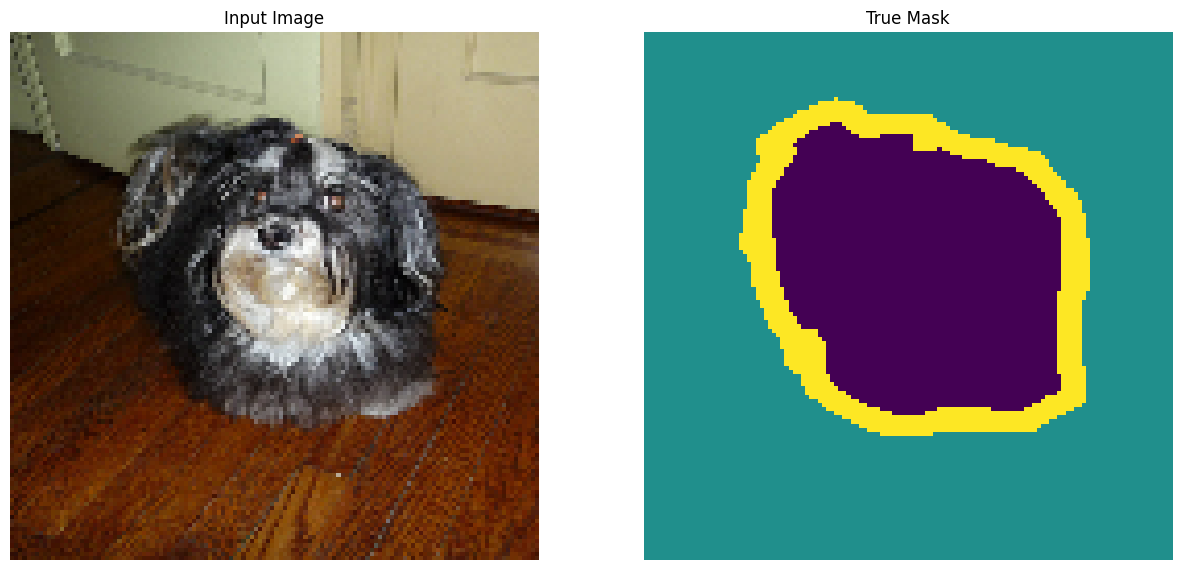

(64, 128, 128, 3) (64, 128, 128, 1)
64 64


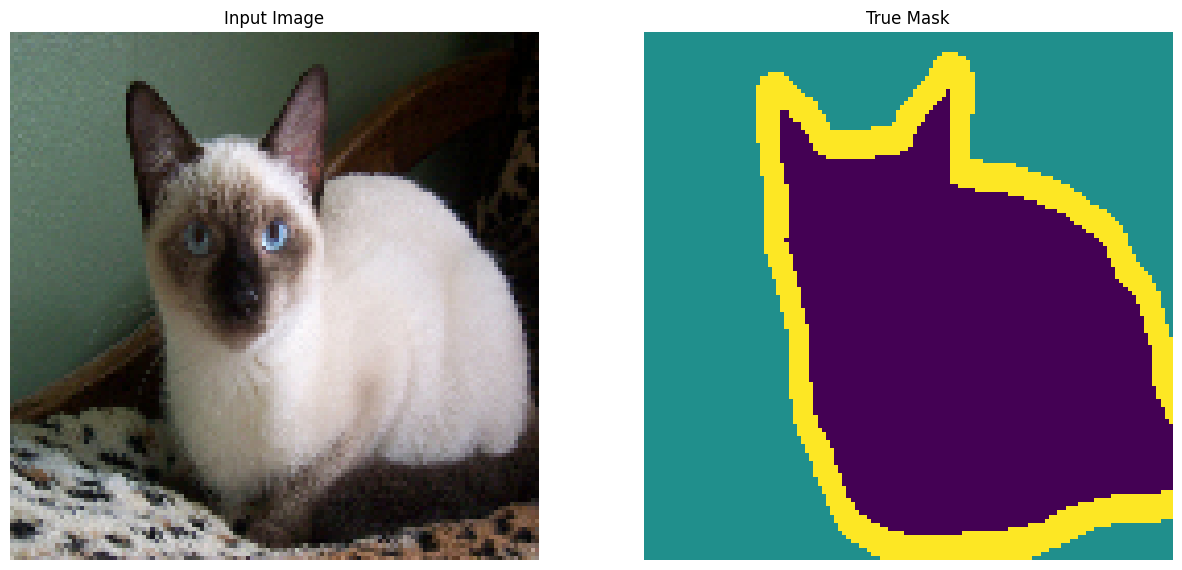

In [ ]:
# Display a sample image and mask from the train batches
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  print(images.shape, masks.shape)
  print(images.shape[0], masks.shape[0])
  display([sample_image, sample_mask])

# Define the Model

In [ ]:
# Load the MobileNetV2 base model without the top layers
base_model = tf.keras.applications.MobileNetV2(input_shape = [128,128,3], include_top = False)

# Define the layer names for the encoder part of U-Net
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_expand_relu', # 4x4
]

# Extract the output of the defined layers from the base model
base_model_outputs = [ base_model.get_layer(name).output for name in layer_names]

# Create the encoder part of U-Net
down_stack = tf.keras.Model(inputs = base_model.input, outputs = base_model_outputs)

down_stack.trainable = False # Freeze the encoder weights

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Define the upsampling layers for the decoder part of U-Net
up_stack = [
    pix2pix.upsample(512,3), # 4x4 --> 8x8
    pix2pix.upsample(256,3), # 8x8--> 16x16
    pix2pix.upsample(128,3), # 16x16--> 32x32
    pix2pix.upsample(64,3), # 32x32--> 64x64
]

In [ ]:
# Define the complete U-Net model
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape = [128,128,3])

  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up,skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x,skip])

  last = tf.keras.layers.Conv2DTranspose(
      filters =output_channels, kernel_size = 3, strides = 2,padding = 'same'
  ) #64x64 -> 128x128
  x = last(x)
  return tf.keras.Model(inputs = inputs, outputs = x)

# Train the model

In [ ]:
# Define the number of output classes
OUTPUT_CLASSES = 3  # Assuming 3 classes for segmentation
model = unet_model(output_channels=OUTPUT_CLASSES) # Define the number of output classes

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


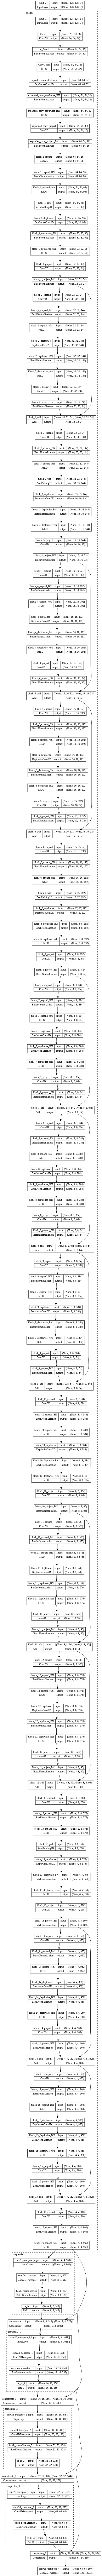

In [ ]:
# Plot the model architecture
tf.keras.utils.plot_model(model,show_shapes = True, expand_nested = True,dpi = 64)

In [ ]:
# Function to create a mask from the predicted mask
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis = -1)
  return pred_mask[..., tf.newaxis][0]

In [ ]:
# Function to display predictions
def show_predictions(dataset= None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display(display_list=[image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image,sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis,...]))])


1/1 [==============================] - 2s 2s/step


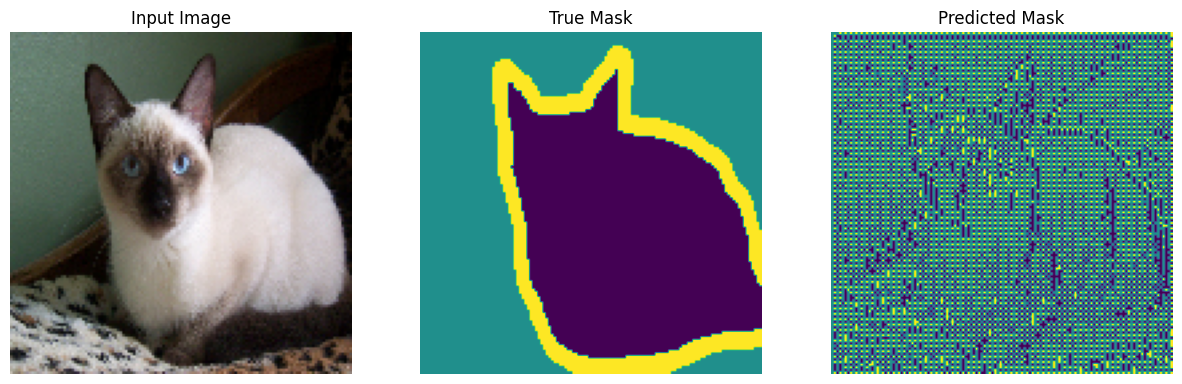

In [ ]:
show_predictions() # Display sample predictions before training

In [ ]:
# Calculate the number of training steps per epoch
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Define the number of epochs and validation steps
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
from IPython.display import clear_output

In [ ]:
# Custom callback to display predictions after each epoch
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs =None):
    clear_output(wait=True)
    show_predictions()
    print('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 60ms/step


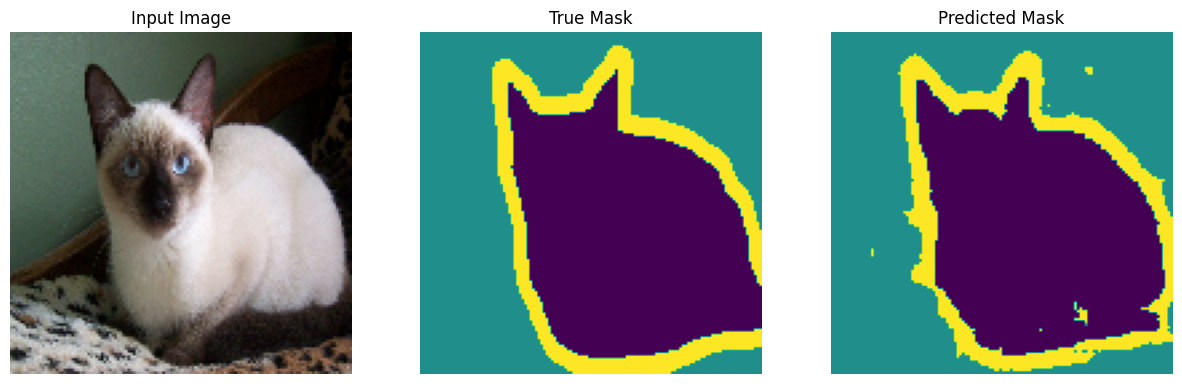


Sample Prediction after epoch 20

57/57 [==============================] - 370s 7s/step - loss: 0.1405 - accuracy: 0.9420 - val_loss: 0.2908 - val_accuracy: 0.9021


In [ ]:
# Train the model
model_history = model.fit(train_batches, epochs = EPOCHS,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          validation_steps = VALIDATION_STEPS,
                          validation_data = test_batches,
                          callbacks = [DisplayCallback()]

)

# Evaluate the model

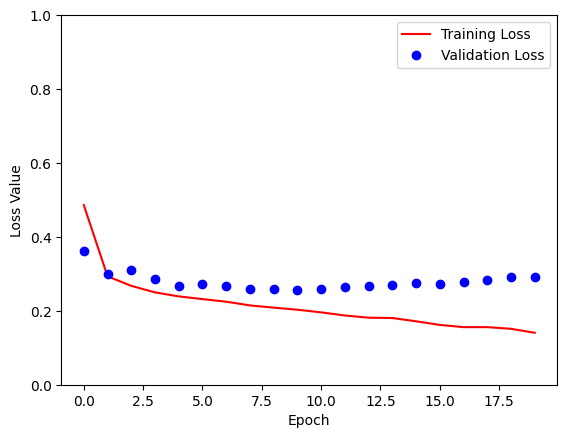

In [ ]:
# Extract the training and validation loss values
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plot the training and validation loss
plt.figure()
plt.plot(model_history.epoch, loss, 'r', label = "Training Loss")
plt.plot(model_history.epoch, val_loss, 'bo', label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0,1])
plt.legend()
plt.show()

# Make Predictions

2/2 [==============================] - 3s 1s/step


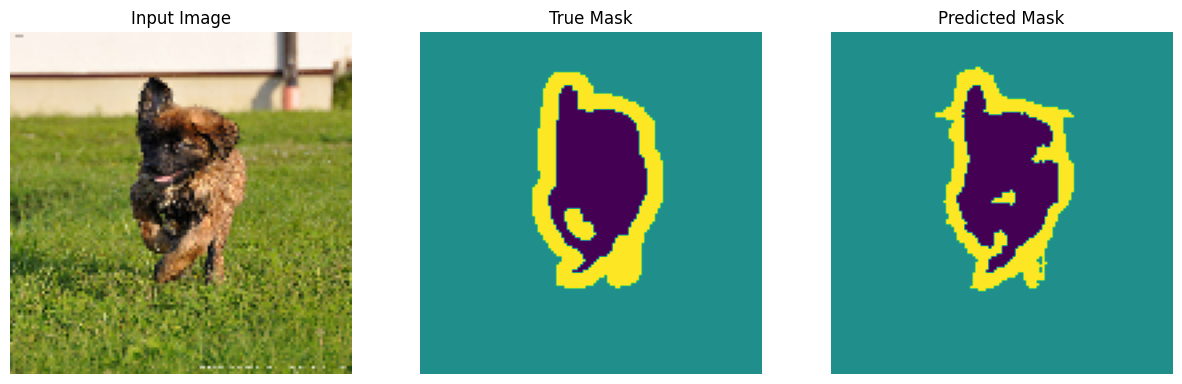

2/2 [==============================] - 2s 1s/step


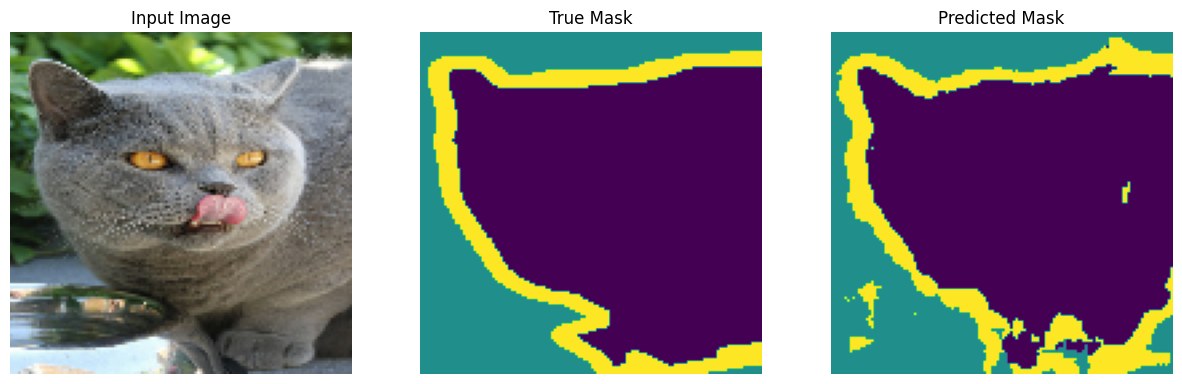

2/2 [==============================] - 2s 1s/step


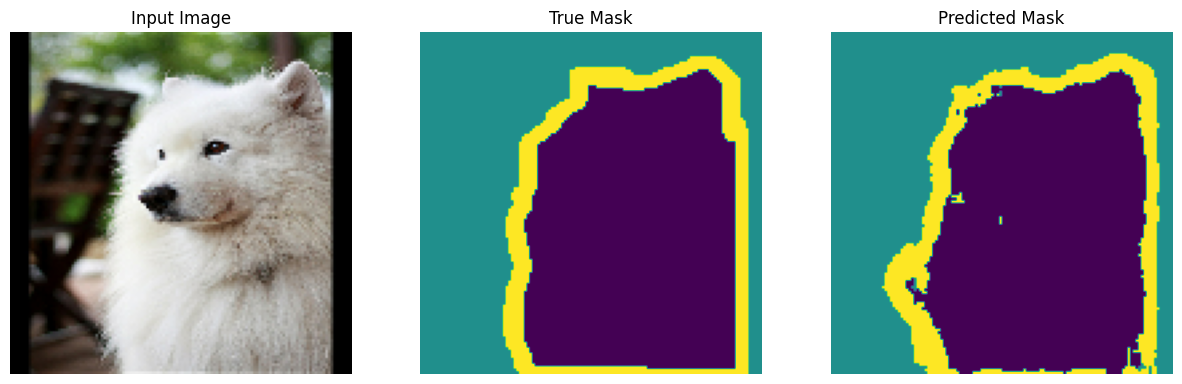

In [ ]:
show_predictions(dataset=test_batches,num=3) # Display predictions on the test dataset